# Introduction to Bayesian Statistics and Pyro 
### By Logan Cerkovnik 

* Intro to Bayesian Methods 
* Pyro Overview
* Pyro Example 

# Frequentist vs Bayesian Approach 

Frequentist statistical methods or Maximium Likihood Estimation methods focus on
determining the best estimate of value given the data

Bayesian methods focus on finding the best distribution (posterior distribution )

Most neural network models and machine learning methods today are based on MLE methods.

Bayesian methods draw name from Baye's Theorem

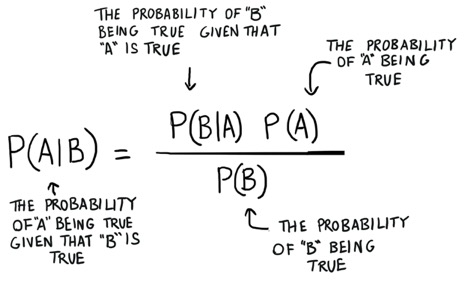

Bayesian methods say that the posterior distribution is equal to the
likihood multiplied the prior distribution divided by a normalizing factor 
called the marginal likihood


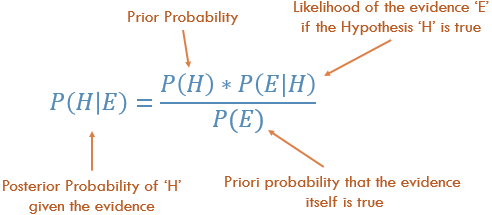

# Note on Prior Distributions:

Prior distribution encodes all past knowledge into model. 

They represent the hyperparameters/ hyperdistributions of the parametric distributions? 
eg a normal distrbution of posterior normal distribution mean. 

This allows expert knowledge and some degree of bias to be injected into the model.
"Flat Priors" are those that only rely on observed data as opposed to previous knowledge
Prior Distribution specification is usually where frequentist / bayesian disaggreements occur 
if the prior distibution is overly weighted then data will not matter as much 


# how are correct distributions found? 

sample from hyperdistributions to determine posterior values( NUTS, Hamiltonian Monte Carlo, Metropolic Hastings, Gibbs)
or 
use optimization to minimize the difference in the expected versus acutal distribution ( Variational Bayes) 

Sampling Methods don't scale to large datasets or complicated models, but provide theoretical performance garantees 
Variational Methods are only approximate with no garantees, but can explore complicated families of models over large datasets. 

Variational Methods tend to have superior performance on multimodal distributions ( mixture models) regardless of sample size.




# Relevant Packages/Libraries 
    
    Python:
        PYMC3
        PyStan
        Pyro 
        Tensorflow probablity, Edward2  
        
    R:
        brms
        rstan 
        
https://github.com/tensorflow/probability

http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/

# API WAlKTHROUGH

http://docs.pyro.ai/en/0.2.1-release/


# Pyro's +'s

* conditioning / marginalization gives ability to explore counterfactual relationships 
* conditioning / marginalization/ generative modeling gives a really unique way to deal with missing data ( doesn't support complex mask conditioning yet) 
* bayesian optimization can sometimes implictly build sparser models without regularization / dropout 

# Pyro -'s 

* Using more common nueral networks like LSTM or deep convolutional networks doesn't always work out for variational inference 
* optimization is generally more difficult than MLE 
* slower than pymc3 / stan for more traditional statistical modeling that can be done in both  
* Steepish learning curve

In [13]:
import pandas as pd 
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt 
import torch
%matplotlib inline 

p = Path( 'C://Users//lcerkovnik//Downloads//AirQualityUCI')
list(p.rglob('*'))

[WindowsPath('C:/Users/lcerkovnik/Downloads/AirQualityUCI/AirQualityUCI.csv'),
 WindowsPath('C:/Users/lcerkovnik/Downloads/AirQualityUCI/AirQualityUCI.xlsx')]

In [14]:
df = pd.read_csv(p / 'AirQualityUCI.csv' , sep=';' , decimal = ',')
df = df.iloc[:, 0:df.shape[1]-2 ]
df['Date'] = pd.to_datetime( df['Date'] )
df.sort_values(['Date', 'Time'], inplace = True)
df.dropna(axis= 0, inplace=True)
df.shape, df.head()

((9357, 15),
           Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
 510 2004-01-04  00.00.00     1.6       1143.0     106.0       6.3   
 511 2004-01-04  01.00.00     1.2       1044.0     100.0       5.1   
 512 2004-01-04  02.00.00     1.1       1034.0      71.0       4.1   
 513 2004-01-04  03.00.00     0.9        956.0      72.0       4.0   
 514 2004-01-04  04.00.00     0.7        909.0      44.0       2.4   
 
      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
 510          825.0     96.0         986.0     86.0        1477.0        978.0   
 511          770.0     85.0        1031.0     70.0        1425.0        944.0   
 512          716.0     50.0        1085.0     55.0        1405.0        891.0   
 513          713.0   -200.0        1099.0   -200.0        1422.0        849.0   
 514          615.0     57.0        1237.0     49.0        1322.0        790.0   
 
         T    RH      AH  
 510  12.0  61.6  0.8593  
 511  11.5  63.9 

In [15]:
df.columns.values[10]

'PT08.S4(NO2)'

In [16]:
head_vars  = ['Date', 'Time', 'PT08.S5(O3)']
df_head = df[head_vars]
df.drop(columns=head_vars, inplace=True)
df = pd.concat([df_head, df] , axis = 1)
scaler = StandardScaler()
df.iloc[:,2:] = scaler.fit_transform( df.iloc[:,2:])
df.iloc[:,2:] =  df.iloc[:,2:].astype(float)

In [17]:
display(df)

,Date,Time,PT08.S5(O3),CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),T,RH,AH
510,2004-01-04,00.00.00,0.006408,0.461122,0.285038,1.896459,0.107166,-0.203308,-0.282095,0.593242,0.219415,0.183055,0.051427,0.431813,0.197485
511,2004-01-04,01.00.00,-0.068004,0.455971,-0.015130,1.853535,0.078165,-0.363978,-0.324827,0.733004,0.093365,0.071750,0.039853,0.476723,0.197637
512,2004-01-04,02.00.00,-0.184000,0.454683,-0.045450,1.646068,0.053998,-0.521728,-0.460791,0.900718,-0.024807,0.028940,0.021335,0.541159,0.197580
513,2004-01-04,03.00.00,-0.275921,0.452108,-0.281946,1.653222,0.051581,-0.530492,-1.431966,0.944199,-2.033730,0.065328,-0.018016,0.656364,0.196975
514,2004-01-04,04.00.00,-0.405048,0.449532,-0.424450,1.452910,0.012913,-0.816778,-0.433598,1.372802,-0.072076,-0.148720,0.009761,0.529444,0.196731
515,2004-01-04,05.00.00,-0.269355,0.452108,-0.160666,1.460064,0.024997,-0.720375,-0.406406,1.183347,-0.064198,-0.110191,0.028279,0.472818,0.196798
516,2004-01-04,06.00.00,0.026106,0.462410,0.318390,2.096771,0.133750,-0.054322,-0.060667,0.642935,0.069730,0.362855,-0.004127,0.572401,0.196587
517,2004-01-04,07.00.00,1.006597,0.494604,1.397783,4.750911,0.433426,1.158012,0.673541,-0.372668,0.282440,1.193361,-0.006442,0.588022,0.196664
518,2004-01-04,08.00.00,1.801058,0.520360,2.040567,8.592618,0.725852,2.046083,0.813390,-0.795059,0.479393,2.242195,0.049112,0.418145,0.197131
519,2004-01-04,09.00.00,1.536237,0.499755,1.403847,6.410643,0.462427,1.251493,0.525923,-0.509324,0.636956,1.304666,0.148646,0.177973,0.198252


In [18]:
def _rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):
    """Create a view of `array` which for every point gives the n-dimensional
    neighbourhood of size window. New dimensions are added at the end of
    `array` or after the corresponding original dimension.

    Parameters
    ----------
    array : array_like
        Array to which the rolling window is applied.
    window : int or tuple
        Either a single integer to create a window of only the last axis or a
        tuple to create it for the last len(window) axes. 0 can be used as a
        to ignore a dimension in the window.
    asteps : tuple
        Aligned at the last axis, new steps for the original array, ie. for
        creation of non-overlapping windows. (Equivalent to slicing result)
    wsteps : int or tuple (same size as window)
        steps for the added window dimensions. These can be 0 to repeat values
        along the axis.
    axes: int or tuple
        If given, must have the same size as window. In this case window is
        interpreted as the size in the dimension given by axes. IE. a window
        of (2, 1) is equivalent to window=2 and axis=-2.
    toend : bool
        If False, the new dimensions are right after the corresponding original
        dimension, instead of at the end of the array. Adding the new axes at the
        end makes it easier to get the neighborhood, however toend=False will give
        a more intuitive result if you view the whole array.

    Returns
    -------
    A view on `array` which is smaller to fit the windows and has windows added
    dimensions (0s not counting), ie. every point of `array` is an array of size
    window.
    """
    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger then 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.")

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps

        if np.any(asteps < 1):
            raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
            raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger then the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any "old" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps

    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _

        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtype=int)

        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides

    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]

    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

def tensor2mat( _narr , avars):
    narr = _narr.swapaxes(1, 2).copy()
    all_vars = []
    for a in range(narr.shape[1]):
        all_vars.extend(  (avars + '_' + str(narr.shape[1]-a)).tolist() )
    prenarr = narr.reshape(narr.shape[0], narr.shape[1]*narr.shape[2])
    df = pd.DataFrame(data = prenarr, columns= all_vars)
    return(prenarr, df)

n_memory_steps = 4
n_forecast_steps = 1
narr = _rolling_window(df.values, window=(n_memory_steps+n_forecast_steps, df.shape[1]),)
narr = narr.squeeze()
narr.shape

(9353, 5, 15)

In [19]:
train_x = narr[0:5000, 0:4, 2:]
train_y = narr[0:5000, 4, 2]
train_y = np.expand_dims(train_y, 1) 
train_y = np.expand_dims(train_y, 1) 
train_x = np.swapaxes(train_x, 1, 2)

test_x = narr[5000:, 0:4, 2:]
test_y = narr[5000:, 4, 2]
test_y = np.expand_dims(test_y, 1)
test_y = np.expand_dims(test_y, 1) 
test_x = np.swapaxes(test_x, 1, 2)


train_x.shape, train_y.shape , test_y.shape

((5000, 13, 4), (5000, 1, 1), (4353, 1, 1))

In [20]:
flat_narr, df_flat_train = tensor2mat( train_x, df.columns.values[2:])
flat_narr, df_flat_test = tensor2mat( test_x, df.columns.values[2:])


In [21]:
df_flat_train = df_flat_train.astype(float)
df_flat_test = df_flat_test.astype(float)
test_y = test_y.astype(float).reshape(test_y.shape[0]  , 1)
train_y = train_y.astype(float).reshape(train_y.shape[0]  , 1)
df_flat_train.shape, test_y.shape

((5000, 52), (4353, 1))

In [22]:

import  torch
import torch.nn as nn
from torch.nn.functional import normalize  # noqa: F401
import torch.nn.functional as F

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal, Bernoulli  # noqa: F401
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO 
from pyro.optim import Adam

pyro.get_param_store().clear()

In [123]:
# df_flat_train.dtypes

In [37]:
X_train, Y_train = Variable(torch.Tensor(df_flat_train.values)), Variable(torch.Tensor(train_y))
X_test, Y_test = Variable(torch.Tensor(df_flat_test.values)), Variable(torch.Tensor(test_y))
data = torch.cat((X_train, Y_train), 1)

In [38]:
# get array of batch indices
# Adapted in part from : https://medium.com/@alexrachnog/financial-forecasting-with-probabilistic-programming-and-pyro-db68ab1a1dba

def get_batch_indices(N, batch_size):
    all_batches = np.arange(0, N, batch_size)
    if all_batches[-1] != N:
        all_batches = list(all_batches) + [N]
    return all_batches

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.predict(x)
        return x

first_layer = len(X_train.data.numpy()[0])
second_layer = 25   
    
softplus = nn.Softplus()
regression_model = Net(first_layer, second_layer)

In [39]:
def model(data):

    mu = Variable(torch.zeros(second_layer, first_layer)).type_as(data)
    sigma = Variable(torch.ones(second_layer, first_layer)).type_as(data)
    bias_mu = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma = Variable(torch.ones(second_layer)).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    mu2 = Variable(torch.zeros(1, second_layer)).type_as(data)
    sigma2 = Variable(torch.ones(1, second_layer)).type_as(data)
    bias_mu2 = Variable(torch.zeros(1)).type_as(data)
    bias_sigma2 = Variable(torch.ones(1)).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        x_data = data[:, :-1]
        y_data = data[:, -1]
        # run the regressor forward conditioned on inputs
        prediction_mean = lifted_reg_model(x_data).squeeze()
        pyro.sample("obs",
                    Normal(prediction_mean, Variable(torch.ones(data.size(0))).type_as(data)),
                    obs=y_data.squeeze())
        

def guide(data):
    
    w_mu = Variable(torch.randn(second_layer, first_layer).type_as(data.data), requires_grad=True)
    w_log_sig = Variable(0.1 * torch.ones(second_layer, first_layer).type_as(data.data), requires_grad=True)
    b_mu = Variable(torch.randn(second_layer).type_as(data.data), requires_grad=True)
    b_log_sig = Variable(0.1 * torch.ones(second_layer).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    
    # gaussian guide distributions for w and b
    w_dist = Normal(mw_param, sw_param)
    b_dist = Normal(mb_param, sb_param)
    
    w_mu2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    w_log_sig2 = Variable(0.1 * torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    b_mu2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
    b_log_sig2 = Variable(0.1 * torch.ones(1).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param2 = pyro.param("guide_mean_weight2", w_mu2)
    sw_param2 = softplus(pyro.param("guide_log_sigma_weight2", w_log_sig2))
    mb_param2 = pyro.param("guide_mean_bias2", b_mu2)
    sb_param2 = softplus(pyro.param("guide_log_sigma_bias2", b_log_sig2))
    
    # gaussian guide distributions for w and b
    w_dist2 = Normal(mw_param2, sw_param2)
    b_dist2 = Normal(mb_param2, sb_param2)
      
    dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}
    
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor
    return lifted_module()

In [ ]:
# instantiate optim and inference objects
optim = Adam({"lr": 0.0001})
svi = SVI(model, guide, optim, loss= Trace_ELBO())
# svi = SVI(model, guide, optim, loss= JitTrace_ELBO() )

N = len(X_train)

for j in range(3000):
    epoch_loss = 0.0
    perm = torch.randperm(N)
    # shuffle data
    data = data[perm]
    # get indices of each batch
    all_batches = get_batch_indices(N, 64)
    for ix, batch_start in enumerate(all_batches[:-1]):
        batch_end = all_batches[ix + 1]
        batch_data = data[batch_start: batch_end]        
        epoch_loss += svi.step(batch_data)
    if j % 100 == 0:
        print(j, "avg loss {}".format(epoch_loss/float(N)))

0 avg loss 101713.60351095269
100 avg loss 46656.09716741705


<Figure size 432x288 with 0 Axes>

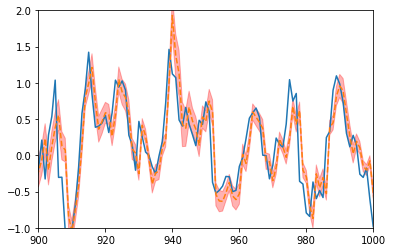

In [169]:
preds = []
for i in range(1000):
    sampled_reg_model = guide(X_test)
    pred = sampled_reg_model(X_test).data.numpy().flatten()
    preds.append(pred)

preds = np.array(preds)
mean = np.mean(preds, axis=0)
std = np.std(preds, axis=0) 
y_test = Y_test.data.numpy()
x = np.arange(len(y_test))

plt.figure()
# plt.plot(original)
# plt.plot(predicted, linestyle = '--')
# plt.show()

plt.figure()
plt.plot(x, y_test)
plt.plot(x, mean, linestyle = '--')
plt.fill_between(x, mean-1*std, mean+1*std, alpha = 0.3, color = 'red')
plt.axis([900, 1000, -1, 2])

plt.show()

[0, 500, -2, 3]

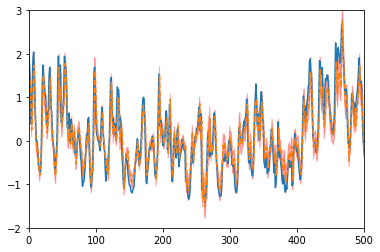

In [166]:

plt.figure()
plt.plot(x, y_test)
plt.plot(x, mean, linestyle = '--')
plt.fill_between(x, mean-std, mean+std, alpha = 0.3, color = 'red')
plt.axis([0, 500, -2, 3])


In [32]:
from torch.utils.data.dataset import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader

class np_dset(Dataset):
    def __init__(self, x_arr, y_arr):
        self.x_arr = torch.tensor(x_arr).float()
        self.y_arr = torch.tensor(y_arr).float()

    def __getitem__(self, idx):
        return self.x_arr[idx, :], self.y_arr[idx, :]

    def __len__(self):
        return self.x_arr.shape[0]
    

ds_train = np_dset( df_flat_train.values, train_y )
ds_test = np_dset( df_flat_test.values , test_y )

train_loader = DataLoader(ds_train, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(ds_test, batch_size=512, shuffle=False, num_workers=0)


In [34]:
mle_nn = Net(first_layer, second_layer)
optimiser = torch.optim.Adam(mle_nn.parameters(), lr=0.001)

device = torch.device("cuda")

model = mle_nn.to(device)
criterion = torch.nn.MSELoss()

total_loss = 0
total_step = len(train_loader)
num_epochs = 1000
i = 0

device = torch.device('cuda')

model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    train_step = 0 
    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        output = mle_nn(input)
        train_step +=1
        optimiser.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimiser.step()

        total_loss += loss.item()
         
    with torch.no_grad():  
        total_test_loss = 0
        test_step = 0
        for input, target in test_loader:
            input, target = input.to(device), target.to(device)
            output = mle_nn(input)
            loss = criterion(output, target)
            total_test_loss += loss.item()
            test_step += 1
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, total_loss/train_step , total_test_loss/test_step))


Epoch [1/1000], Step [20/20], Loss: 0.4621, Test Loss: 0.4252
Epoch [2/1000], Step [20/20], Loss: 0.2836, Test Loss: 0.3555
Epoch [3/1000], Step [20/20], Loss: 0.2305, Test Loss: 0.3069
Epoch [4/1000], Step [20/20], Loss: 0.2142, Test Loss: 0.2904
Epoch [5/1000], Step [20/20], Loss: 0.2012, Test Loss: 0.2679
Epoch [6/1000], Step [20/20], Loss: 0.1932, Test Loss: 0.2552
Epoch [7/1000], Step [20/20], Loss: 0.1834, Test Loss: 0.2478
Epoch [8/1000], Step [20/20], Loss: 0.1820, Test Loss: 0.2383
Epoch [9/1000], Step [20/20], Loss: 0.1757, Test Loss: 0.2328
Epoch [10/1000], Step [20/20], Loss: 0.1716, Test Loss: 0.2341
Epoch [11/1000], Step [20/20], Loss: 0.1701, Test Loss: 0.2321
Epoch [12/1000], Step [20/20], Loss: 0.1694, Test Loss: 0.2320
Epoch [13/1000], Step [20/20], Loss: 0.1694, Test Loss: 0.2265
Epoch [14/1000], Step [20/20], Loss: 0.1662, Test Loss: 0.2235
Epoch [15/1000], Step [20/20], Loss: 0.1638, Test Loss: 0.2216
Epoch [16/1000], Step [20/20], Loss: 0.1651, Test Loss: 0.2321
E

Epoch [130/1000], Step [20/20], Loss: 0.1577, Test Loss: 0.2188
Epoch [131/1000], Step [20/20], Loss: 0.1568, Test Loss: 0.2081
Epoch [132/1000], Step [20/20], Loss: 0.1559, Test Loss: 0.2079
Epoch [133/1000], Step [20/20], Loss: 0.1579, Test Loss: 0.2084
Epoch [134/1000], Step [20/20], Loss: 0.1594, Test Loss: 0.2082
Epoch [135/1000], Step [20/20], Loss: 0.1559, Test Loss: 0.2072
Epoch [136/1000], Step [20/20], Loss: 0.1575, Test Loss: 0.2094
Epoch [137/1000], Step [20/20], Loss: 0.1580, Test Loss: 0.2079
Epoch [138/1000], Step [20/20], Loss: 0.1561, Test Loss: 0.2078
Epoch [139/1000], Step [20/20], Loss: 0.1560, Test Loss: 0.2074
Epoch [140/1000], Step [20/20], Loss: 0.1572, Test Loss: 0.2094
Epoch [141/1000], Step [20/20], Loss: 0.1581, Test Loss: 0.2085
Epoch [142/1000], Step [20/20], Loss: 0.1576, Test Loss: 0.2094
Epoch [143/1000], Step [20/20], Loss: 0.1568, Test Loss: 0.2113
Epoch [144/1000], Step [20/20], Loss: 0.1559, Test Loss: 0.2086
Epoch [145/1000], Step [20/20], Loss: 0.

Epoch [259/1000], Step [20/20], Loss: 0.1558, Test Loss: 0.2064
Epoch [260/1000], Step [20/20], Loss: 0.1601, Test Loss: 0.2101
Epoch [261/1000], Step [20/20], Loss: 0.1593, Test Loss: 0.2062
Epoch [262/1000], Step [20/20], Loss: 0.1558, Test Loss: 0.2079
Epoch [263/1000], Step [20/20], Loss: 0.1544, Test Loss: 0.2076
Epoch [264/1000], Step [20/20], Loss: 0.1558, Test Loss: 0.2099
Epoch [265/1000], Step [20/20], Loss: 0.1565, Test Loss: 0.2071
Epoch [266/1000], Step [20/20], Loss: 0.1580, Test Loss: 0.2179
Epoch [267/1000], Step [20/20], Loss: 0.1566, Test Loss: 0.2101
Epoch [268/1000], Step [20/20], Loss: 0.1570, Test Loss: 0.2116
Epoch [269/1000], Step [20/20], Loss: 0.1559, Test Loss: 0.2075
Epoch [270/1000], Step [20/20], Loss: 0.1565, Test Loss: 0.2067
Epoch [271/1000], Step [20/20], Loss: 0.1559, Test Loss: 0.2074
Epoch [272/1000], Step [20/20], Loss: 0.1568, Test Loss: 0.2072
Epoch [273/1000], Step [20/20], Loss: 0.1587, Test Loss: 0.2071
Epoch [274/1000], Step [20/20], Loss: 0.

Epoch [389/1000], Step [20/20], Loss: 0.1560, Test Loss: 0.2057
Epoch [390/1000], Step [20/20], Loss: 0.1542, Test Loss: 0.2061
Epoch [391/1000], Step [20/20], Loss: 0.1568, Test Loss: 0.2084
Epoch [392/1000], Step [20/20], Loss: 0.1570, Test Loss: 0.2105
Epoch [393/1000], Step [20/20], Loss: 0.1563, Test Loss: 0.2066
Epoch [394/1000], Step [20/20], Loss: 0.1559, Test Loss: 0.2069
Epoch [395/1000], Step [20/20], Loss: 0.1548, Test Loss: 0.2068
Epoch [396/1000], Step [20/20], Loss: 0.1577, Test Loss: 0.2067
Epoch [397/1000], Step [20/20], Loss: 0.1565, Test Loss: 0.2067
Epoch [398/1000], Step [20/20], Loss: 0.1573, Test Loss: 0.2076
Epoch [399/1000], Step [20/20], Loss: 0.1561, Test Loss: 0.2069
Epoch [400/1000], Step [20/20], Loss: 0.1565, Test Loss: 0.2074
Epoch [401/1000], Step [20/20], Loss: 0.1582, Test Loss: 0.2072
Epoch [402/1000], Step [20/20], Loss: 0.1552, Test Loss: 0.2086
Epoch [403/1000], Step [20/20], Loss: 0.1562, Test Loss: 0.2133
Epoch [404/1000], Step [20/20], Loss: 0.

Epoch [517/1000], Step [20/20], Loss: 0.1564, Test Loss: 0.2065
Epoch [518/1000], Step [20/20], Loss: 0.1537, Test Loss: 0.2061
Epoch [519/1000], Step [20/20], Loss: 0.1547, Test Loss: 0.2066
Epoch [520/1000], Step [20/20], Loss: 0.1552, Test Loss: 0.2076
Epoch [521/1000], Step [20/20], Loss: 0.1548, Test Loss: 0.2060
Epoch [522/1000], Step [20/20], Loss: 0.1553, Test Loss: 0.2077
Epoch [523/1000], Step [20/20], Loss: 0.1550, Test Loss: 0.2078
Epoch [524/1000], Step [20/20], Loss: 0.1587, Test Loss: 0.2095
Epoch [525/1000], Step [20/20], Loss: 0.1553, Test Loss: 0.2061
Epoch [526/1000], Step [20/20], Loss: 0.1556, Test Loss: 0.2062
Epoch [527/1000], Step [20/20], Loss: 0.1547, Test Loss: 0.2083
Epoch [528/1000], Step [20/20], Loss: 0.1545, Test Loss: 0.2066
Epoch [529/1000], Step [20/20], Loss: 0.1543, Test Loss: 0.2058
Epoch [530/1000], Step [20/20], Loss: 0.1557, Test Loss: 0.2145
Epoch [531/1000], Step [20/20], Loss: 0.1572, Test Loss: 0.2078
Epoch [532/1000], Step [20/20], Loss: 0.

KeyboardInterrupt: 

In [35]:
x_test_t = torch.tensor(df_flat_test.values).float().to(device)
with torch.no_grad():
    y_pred = mle_nn(x_test_t)
y_pred = y_pred.cpu().numpy()
print( np.mean(np.abs(y_pred - test_y)))



0.2805363112033938


In [36]:

# plt.figure()
# plt.plot(original)
# plt.plot(predicted, linestyle = '--')
# plt.show()

plt.figure()
plt.plot(x, y_test)
plt.plot(x, y_pred, color = 'green')

plt.plot(x, mean, linestyle = '--')
plt.fill_between(x, mean-1*std, mean+1*std, alpha = 0.3, color = 'red')
plt.axis([900, 1000, -1, 2])

plt.show()

NameError: name 'x' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# credit: https://medium.com/@alexrachnog/financial-forecasting-with-probabilistic-programming-and-pyro-db68ab1a1dba
#FFNNET
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer
    def forward(self, x):
            x = self.hidden(x)
            x = self.predict(x)
            return x


In [ ]:
from plotnine import *
(ggplot(mtcars, aes('wt', 'mpg', color='factor(gear)'))
 + geom_point()
 + stat_smooth(method='lm')
 + facet_wrap('~gear'))

In [ ]:
#bayesian ffnet

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer
    def forward(self, x):
            x = self.hidden(x)
            x = self.predict(x)
            return x
        
priors = {'hidden.weight': w_prior, 
      'hidden.bias': b_prior,
      'predict.weight': w_prior2,
      'predict.bias': b_prior2}

dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}

for name in pyro.get_param_store().get_all_param_names():
    print name, pyro.param(name).data.numpy()
    


In [ ]:
import pyro
import pyro.distributions as dist
from pyro.contrib.examples.util import print_and_log, set_seed
from pyro.infer import SVI, JitTrace_ELBO, JitTraceEnum_ELBO, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

In [ ]:
from utils.custom_mlp import MLP, Exp
from utils.mnist_cached import MNISTCached, mkdir_p, setup_data_loaders
from utils.vae_plots import mnist_test_tsne_ssvae, plot_conditional_samples_ssvae

In [ ]:


class Exp(nn.Module):
    """
    a custom module for exponentiation of tensors
    """
    def __init__(self):
        super(Exp, self).__init__()

    def forward(self, val):
        return torch.exp(val)


class ConcatModule(nn.Module):
    """
    a custom module for concatenation of tensors
    """
    def __init__(self, allow_broadcast=False):
        self.allow_broadcast = allow_broadcast
        super(ConcatModule, self).__init__()

    def forward(self, *input_args):
        # we have a single object
        if len(input_args) == 1:
            # regardless of type,
            # we don't care about single objects
            # we just index into the object
            input_args = input_args[0]

        # don't concat things that are just single objects
        if torch.is_tensor(input_args):
            return input_args
        else:
            if self.allow_broadcast:
                shape = broadcast_shape(*[s.shape[:-1] for s in input_args]) + (-1,)
                input_args = [s.expand(shape) for s in input_args]
            return torch.cat(input_args, dim=-1)


class ListOutModule(nn.ModuleList):
    """
    a custom module for outputting a list of tensors from a list of nn modules
    """
    def __init__(self, modules):
        super(ListOutModule, self).__init__(modules)

    def forward(self, *args, **kwargs):
        # loop over modules in self, apply same args
        return [mm.forward(*args, **kwargs) for mm in self]


def call_nn_op(op):
    """
    a helper function that adds appropriate parameters when calling
    an nn module representing an operation like Softmax
    :param op: the nn.Module operation to instantiate
    :return: instantiation of the op module with appropriate parameters
    """
    if op in [nn.Softmax, nn.LogSoftmax]:
        return op(dim=1)
    else:
        return op()


In [ ]:

class MLP(nn.Module):

    def __init__(self, mlp_sizes, activation=nn.ReLU, output_activation=None,
                 post_layer_fct=lambda layer_ix, total_layers, layer: None,
                 post_act_fct=lambda layer_ix, total_layers, layer: None,
                 allow_broadcast=False, use_cuda=False):
        # init the module object
        super(MLP, self).__init__()

        assert len(mlp_sizes) >= 2, "Must have input and output layer sizes defined"

        # get our inputs, outputs, and hidden
        input_size, hidden_sizes, output_size = mlp_sizes[0], mlp_sizes[1:-1], mlp_sizes[-1]

        # assume int or list
        assert isinstance(input_size, (int, list, tuple)), "input_size must be int, list, tuple"

        # everything in MLP will be concatted if it's multiple arguments
        last_layer_size = input_size if type(input_size) == int else sum(input_size)

        # everything sent in will be concatted together by default
        all_modules = [ConcatModule(allow_broadcast)]

        # loop over l
        for layer_ix, layer_size in enumerate(hidden_sizes):
            assert type(layer_size) == int, "Hidden layer sizes must be ints"

            # get our nn layer module (in this case nn.Linear by default)
            cur_linear_layer = nn.Linear(last_layer_size, layer_size)

            # for numerical stability -- initialize the layer properly
            cur_linear_layer.weight.data.normal_(0, 0.001)
            cur_linear_layer.bias.data.normal_(0, 0.001)

            # use GPUs to share data during training (if available)
            if use_cuda:
                cur_linear_layer = nn.DataParallel(cur_linear_layer)

            # add our linear layer
            all_modules.append(cur_linear_layer)

            # handle post_linear
            post_linear = post_layer_fct(layer_ix + 1, len(hidden_sizes), all_modules[-1])

            # if we send something back, add it to sequential
            # here we could return a batch norm for example
            if post_linear is not None:
                all_modules.append(post_linear)

            # handle activation (assumed no params -- deal with that later)
            all_modules.append(activation())

            # now handle after activation
            post_activation = post_act_fct(layer_ix + 1, len(hidden_sizes), all_modules[-1])

            # handle post_activation if not null
            # could add batch norm for example
            if post_activation is not None:
                all_modules.append(post_activation)

            # save the layer size we just created
            last_layer_size = layer_size

        # now we have all of our hidden layers
        # we handle outputs
        assert isinstance(output_size, (int, list, tuple)), "output_size must be int, list, tuple"

        if type(output_size) == int:
            all_modules.append(nn.Linear(last_layer_size, output_size))
            if output_activation is not None:
                all_modules.append(call_nn_op(output_activation)
                                   if isclass(output_activation) else output_activation)
        else:

            # we're going to have a bunch of separate layers we can spit out (a tuple of outputs)
            out_layers = []

            # multiple outputs? handle separately
            for out_ix, out_size in enumerate(output_size):

                # for a single output object, we create a linear layer and some weights
                split_layer = []

                # we have an activation function
                split_layer.append(nn.Linear(last_layer_size, out_size))

                # then we get our output activation (either we repeat all or we index into a same sized array)
                act_out_fct = output_activation if not isinstance(output_activation, (list, tuple)) \
                    else output_activation[out_ix]

                if(act_out_fct):
                    # we check if it's a class. if so, instantiate the object
                    # otherwise, use the object directly (e.g. pre-instaniated)
                    split_layer.append(call_nn_op(act_out_fct)
                                       if isclass(act_out_fct) else act_out_fct)

                # our outputs is just a sequential of the two
                out_layers.append(nn.Sequential(*split_layer))

            all_modules.append(ListOutModule(out_layers))

        # now we have all of our modules, we're ready to build our sequential!
        # process mlps in order, pretty standard here
        self.sequential_mlp = nn.Sequential(*all_modules)

    # pass through our sequential for the output!
    def forward(self, *args, **kwargs):
        return self.sequential_mlp.forward(*args, **kwargs)

In [ ]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks) and models & guides needed to train a
    semi-supervised variational auto-encoder on the MNIST image dataset
    :param output_size: size of the tensor representing the class label (10 for MNIST since
                        we represent the class labels as a one-hot vector with 10 components)
    :param input_size: size of the tensor representing the image (28*28 = 784 for our MNIST dataset
                       since we flatten the images and scale the pixels to be in [0,1])
    :param z_dim: size of the tensor representing the latent random variable z
                  (handwriting style for our MNIST dataset)
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """
    def __init__(self, output_size=10, input_size=784, z_dim=50, hidden_layers=(500,),
                 config_enum=None, use_cuda=False, aux_loss_multiplier=None):

        super(SSVAE, self).__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):

        z_dim = self.z_dim
        hidden_sizes = self.hidden_layers

        # define the neural networks used later in the model and the guide.
        # these networks are MLPs (multi-layered perceptrons or simple feed-forward networks)
        # where the provided activation parameter is used on every linear layer except
        # for the output layer where we use the provided output_activation parameter
        self.encoder_y = MLP([self.input_size] + hidden_sizes + [self.output_size],
                             activation=nn.Softplus,
                             output_activation=nn.Softmax,
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
        self.encoder_z = MLP([self.input_size + self.output_size] +
                             hidden_sizes + [[z_dim, z_dim]],
                             activation=nn.Softplus,
                             output_activation=[None, Exp],
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        self.decoder = MLP([z_dim + self.output_size] +
                           hidden_sizes + [self.input_size],
                           activation=nn.Softplus,
                           output_activation=nn.Sigmoid,
                           allow_broadcast=self.allow_broadcast,
                           use_cuda=self.use_cuda)

        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # handwriting style (latent)
        p(y|x) = categorical(I/10.)     # which digit (semi-supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`
        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        with pyro.iarange("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim])
            prior_scale = xs.new_ones([batch_size, self.z_dim])
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).independent(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = xs.new_ones([batch_size, self.output_size]) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)

            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).independent(1), obs=xs)
            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = categorical(alpha(x))              # infer digit from an image
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer handwriting style from an image and the digit
        loc, scale are given by a neural network `encoder_z`
        alpha is given by a neural network `encoder_y`
        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):

            # if the class label (the digit) is not supervised, sample
            # (and score) the digit with the variational distribution
            # q(y|x) = categorical(alpha(x))
            if ys is None:
                alpha = self.encoder_y.forward(xs)
                ys = pyro.sample("y", dist.OneHotCategorical(alpha))

            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z.forward([xs, ys])
            pyro.sample("z", dist.Normal(loc, scale).independent(1))

    def classifier(self, xs):
        """
        classify an image (or a batch of images)
        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        # use the trained model q(y|x) = categorical(alpha(x))
        # compute all class probabilities for the image(s)
        alpha = self.encoder_y.forward(xs)

        # get the index (digit) that corresponds to
        # the maximum predicted class probability
        res, ind = torch.topk(alpha, 1)

        # convert the digit(s) to one-hot tensor(s)
        ys = xs.new_zeros(alpha.size())
        ys = ys.scatter_(1, ind, 1.0)
        return ys

    def model_classify(self, xs, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                alpha = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=ys)

    def guide_classify(self, xs, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

In [ ]:
def run_inference_for_epoch(data_loaders, losses, periodic_interval_batches):
    """
    runs the inference algorithm for an epoch
    returns the values of all losses separately on supervised and unsupervised parts
    """
    num_losses = len(losses)

    # compute number of batches for an epoch
    sup_batches = len(data_loaders["sup"])
    unsup_batches = len(data_loaders["unsup"])
    batches_per_epoch = sup_batches + unsup_batches

    # initialize variables to store loss values
    epoch_losses_sup = [0.] * num_losses
    epoch_losses_unsup = [0.] * num_losses

    # setup the iterators for training data loaders
    sup_iter = iter(data_loaders["sup"])
    unsup_iter = iter(data_loaders["unsup"])

    # count the number of supervised batches seen in this epoch
    ctr_sup = 0
    for i in range(batches_per_epoch):

        # whether this batch is supervised or not
        is_supervised = (i % periodic_interval_batches == 1) and ctr_sup < sup_batches

        # extract the corresponding batch
        if is_supervised:
            (xs, ys) = next(sup_iter)
            ctr_sup += 1
        else:
            (xs, ys) = next(unsup_iter)

        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            if is_supervised:
                new_loss = losses[loss_id].step(xs, ys)
                epoch_losses_sup[loss_id] += new_loss
            else:
                new_loss = losses[loss_id].step(xs)
                epoch_losses_unsup[loss_id] += new_loss

    # return the values of all losses
    return epoch_losses_sup, epoch_losses_unsup


def get_accuracy(data_loader, classifier_fn, batch_size):
    """
    compute the accuracy over the supervised training set or the testing set
    """
    predictions, actuals = [], []

    # use the appropriate data loader
    for (xs, ys) in data_loader:
        # use classification function to compute all predictions for each batch
        predictions.append(classifier_fn(xs))
        actuals.append(ys)

    # compute the number of accurate predictions
    accurate_preds = 0
    for pred, act in zip(predictions, actuals):
        for i in range(pred.size(0)):
            v = torch.sum(pred[i] == act[i])
            accurate_preds += (v.item() == 10)

    # calculate the accuracy between 0 and 1
    accuracy = (accurate_preds * 1.0) / (len(predictions) * batch_size)
    return accuracy


def visualize(ss_vae, viz, test_loader):
    if viz:
        plot_conditional_samples_ssvae(ss_vae, viz)
        mnist_test_tsne_ssvae(ssvae=ss_vae, test_loader=test_loader)


def main(args):
    """
    run inference for SS-VAE
    :param args: arguments for SS-VAE
    :return: None
    """
    if args.seed is not None:
        set_seed(args.seed, args.cuda)

    viz = None
    if args.visualize:
        viz = Visdom()
        mkdir_p("./vae_results")

    # batch_size: number of images (and labels) to be considered in a batch
    ss_vae = SSVAE(z_dim=args.z_dim,
                   hidden_layers=args.hidden_layers,
                   use_cuda=args.cuda,
                   config_enum=args.enum_discrete,
                   aux_loss_multiplier=args.aux_loss_multiplier)

    # setup the optimizer
    adam_params = {"lr": args.learning_rate, "betas": (args.beta_1, 0.999)}
    optimizer = Adam(adam_params)

    # set up the loss(es) for inference. wrapping the guide in config_enumerate builds the loss as a sum
    # by enumerating each class label for the sampled discrete categorical distribution in the model
    guide = config_enumerate(ss_vae.guide, args.enum_discrete, expand=True)
    elbo = (JitTraceEnum_ELBO if args.jit else TraceEnum_ELBO)(max_iarange_nesting=1)
    loss_basic = SVI(ss_vae.model, guide, optimizer, loss=elbo)

    # build a list of all losses considered
    losses = [loss_basic]

    # aux_loss: whether to use the auxiliary loss from NIPS 14 paper (Kingma et al)
    if args.aux_loss:
        elbo = JitTrace_ELBO() if args.jit else Trace_ELBO()
        loss_aux = SVI(ss_vae.model_classify, ss_vae.guide_classify, optimizer, loss=elbo)
        losses.append(loss_aux)

    try:
        # setup the logger if a filename is provided
        logger = open(args.logfile, "w") if args.logfile else None

        data_loaders = setup_data_loaders(MNISTCached, args.cuda, args.batch_size, sup_num=args.sup_num)

        # how often would a supervised batch be encountered during inference
        # e.g. if sup_num is 3000, we would have every 16th = int(50000/3000) batch supervised
        # until we have traversed through the all supervised batches
        periodic_interval_batches = int(MNISTCached.train_data_size / (1.0 * args.sup_num))

        # number of unsupervised examples
        unsup_num = MNISTCached.train_data_size - args.sup_num

        # initializing local variables to maintain the best validation accuracy
        # seen across epochs over the supervised training set
        # and the corresponding testing set and the state of the networks
        best_valid_acc, corresponding_test_acc = 0.0, 0.0

        # run inference for a certain number of epochs
        for i in range(0, args.num_epochs):

            # get the losses for an epoch
            epoch_losses_sup, epoch_losses_unsup = \
                run_inference_for_epoch(data_loaders, losses, periodic_interval_batches)

            # compute average epoch losses i.e. losses per example
            avg_epoch_losses_sup = map(lambda v: v / args.sup_num, epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup)

            # store the loss and validation/testing accuracies in the logfile
            str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
            str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))

            str_print = "{} epoch: avg losses {}".format(i, "{} {}".format(str_loss_sup, str_loss_unsup))

            validation_accuracy = get_accuracy(data_loaders["valid"], ss_vae.classifier, args.batch_size)
            str_print += " validation accuracy {}".format(validation_accuracy)

            # this test accuracy is only for logging, this is not used
            # to make any decisions during training
            test_accuracy = get_accuracy(data_loaders["test"], ss_vae.classifier, args.batch_size)
            str_print += " test accuracy {}".format(test_accuracy)

            # update the best validation accuracy and the corresponding
            # testing accuracy and the state of the parent module (including the networks)
            if best_valid_acc < validation_accuracy:
                best_valid_acc = validation_accuracy
                corresponding_test_acc = test_accuracy

            print_and_log(logger, str_print)

        final_test_accuracy = get_accuracy(data_loaders["test"], ss_vae.classifier, args.batch_size)
        print_and_log(logger, "best validation accuracy {} corresponding testing accuracy {} "
                      "last testing accuracy {}".format(best_valid_acc, corresponding_test_acc, final_test_accuracy))

        # visualize the conditional samples
        visualize(ss_vae, viz, data_loaders["test"])
    finally:
        # close the logger file object if we opened it earlier
        if args.logfile:
            logger.close()

In [ ]:
if args.seed is not None:
    set_seed(args.seed, args.cuda)

viz = None
if args.visualize:
    viz = Visdom()
    mkdir_p("./vae_results")

In [ ]:
# batch_size: number of images (and labels) to be considered in a batch
ss_vae = SSVAE(z_dim=args.z_dim,
               hidden_layers=args.hidden_layers,
               use_cuda=args.cuda,
               config_enum=args.enum_discrete,
               aux_loss_multiplier=args.aux_loss_multiplier)

# setup the optimizer
adam_params = {"lr": args.learning_rate, "betas": (args.beta_1, 0.999)}
optimizer = Adam(adam_params)

In [ ]:
# set up the loss(es) for inference. wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label for the sampled discrete categorical distribution in the model
guide = config_enumerate(ss_vae.guide, args.enum_discrete, expand=True)
elbo = (JitTraceEnum_ELBO if args.jit else TraceEnum_ELBO)(max_iarange_nesting=1)
loss_basic = SVI(ss_vae.model, guide, optimizer, loss=elbo)

# build a list of all losses considered
losses = [loss_basic]

# aux_loss: whether to use the auxiliary loss from NIPS 14 paper (Kingma et al)
if args.aux_loss:
    elbo = JitTrace_ELBO() if args.jit else Trace_ELBO()
    loss_aux = SVI(ss_vae.model_classify, ss_vae.guide_classify, optimizer, loss=elbo)
    losses.append(loss_aux)

try:
    # setup the logger if a filename is provided
    logger = open(args.logfile, "w") if args.logfile else None

    data_loaders = setup_data_loaders(MNISTCached, args.cuda, args.batch_size, sup_num=args.sup_num)

    # how often would a supervised batch be encountered during inference
    # e.g. if sup_num is 3000, we would have every 16th = int(50000/3000) batch supervised
    # until we have traversed through the all supervised batches
    periodic_interval_batches = int(MNISTCached.train_data_size / (1.0 * args.sup_num))

    # number of unsupervised examples
    unsup_num = MNISTCached.train_data_size - args.sup_num

    # initializing local variables to maintain the best validation accuracy
    # seen across epochs over the supervised training set
    # and the corresponding testing set and the state of the networks
    best_valid_acc, corresponding_test_acc = 0.0, 0.0

    # run inference for a certain number of epochs
    for i in range(0, args.num_epochs):

        # get the losses for an epoch
        epoch_losses_sup, epoch_losses_unsup = \
            run_inference_for_epoch(data_loaders, losses, periodic_interval_batches)

        # compute average epoch losses i.e. losses per example
        avg_epoch_losses_sup = map(lambda v: v / args.sup_num, epoch_losses_sup)
        avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup)

        # store the loss and validation/testing accuracies in the logfile
        str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
        str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))

        str_print = "{} epoch: avg losses {}".format(i, "{} {}".format(str_loss_sup, str_loss_unsup))

        validation_accuracy = get_accuracy(data_loaders["valid"], ss_vae.classifier, args.batch_size)
        str_print += " validation accuracy {}".format(validation_accuracy)

        # this test accuracy is only for logging, this is not used
        # to make any decisions during training
        test_accuracy = get_accuracy(data_loaders["test"], ss_vae.classifier, args.batch_size)
        str_print += " test accuracy {}".format(test_accuracy)

        # update the best validation accuracy and the corresponding
        # testing accuracy and the state of the parent module (including the networks)
        if best_valid_acc < validation_accuracy:
            best_valid_acc = validation_accuracy
            corresponding_test_acc = test_accuracy

        print_and_log(logger, str_print)

    final_test_accuracy = get_accuracy(data_loaders["test"], ss_vae.classifier, args.batch_size)
    print_and_log(logger, "best validation accuracy {} corresponding testing accuracy {} "
                  "last testing accuracy {}".format(best_valid_acc, corresponding_test_acc, final_test_accuracy))

    # visualize the conditional samples
    visualize(ss_vae, viz, data_loaders["test"])
finally:
    # close the logger file object if we opened it earlier
    if args.logfile:
        logger.close()

In [ ]:
EXAMPLE_RUN = "example run: python ss_vae_M2.py --seed 0 --cuda -n 2 --aux-loss -alm 46 -enum parallel " \
              "-sup 3000 -zd 50 -hl 500 -lr 0.00042 -b1 0.95 -bs 200 -log ./tmp.log"

if __name__ == "__main__":

    parser = argparse.ArgumentParser(description="SS-VAE\n{}".format(EXAMPLE_RUN))

    parser.add_argument('--cuda', action='store_true',
                        help="use GPU(s) to speed up training")
    parser.add_argument('--jit', action='store_true',
                        help="use PyTorch jit to speed up training")
    parser.add_argument('-n', '--num-epochs', default=50, type=int,
                        help="number of epochs to run")
    parser.add_argument('--aux-loss', action="store_true",
                        help="whether to use the auxiliary loss from NIPS 14 paper "
                             "(Kingma et al). It is not used by default ")
    parser.add_argument('-alm', '--aux-loss-multiplier', default=46, type=float,
                        help="the multiplier to use with the auxiliary loss")
    parser.add_argument('-enum', '--enum-discrete', default="parallel",
                        help="parallel, sequential or none. uses parallel enumeration by default")
    parser.add_argument('-sup', '--sup-num', default=3000,
                        type=float, help="supervised amount of the data i.e. "
                                         "how many of the images have supervised labels")
    parser.add_argument('-zd', '--z-dim', default=50, type=int,
                        help="size of the tensor representing the latent variable z "
                             "variable (handwriting style for our MNIST dataset)")
    parser.add_argument('-hl', '--hidden-layers', nargs='+', default=[500], type=int,
                        help="a tuple (or list) of MLP layers to be used in the neural networks "
                             "representing the parameters of the distributions in our model")
    parser.add_argument('-lr', '--learning-rate', default=0.00042, type=float,
                        help="learning rate for Adam optimizer")
    parser.add_argument('-b1', '--beta-1', default=0.9, type=float,
                        help="beta-1 parameter for Adam optimizer")
    parser.add_argument('-bs', '--batch-size', default=200, type=int,
                        help="number of images (and labels) to be considered in a batch")
    parser.add_argument('-log', '--logfile', default="./tmp.log", type=str,
                        help="filename for logging the outputs")
    parser.add_argument('--seed', default=None, type=int,
                        help="seed for controlling randomness in this example")
    parser.add_argument('--visualize', action="store_true",
                        help="use a visdom server to visualize the embeddings")
    args = parser.parse_args()

    # some assertions to make sure that batching math assumptions are met
    assert args.sup_num % args.batch_size == 0, "assuming simplicity of batching math"
    assert MNISTCached.validation_size % args.batch_size == 0, \
        "batch size should divide the number of validation examples"
    assert MNISTCached.train_data_size % args.batch_size == 0, \
        "batch size doesn't divide total number of training data examples"
    assert MNISTCached.test_size % args.batch_size == 0, "batch size should divide the number of test examples"

    main(args)